## 历史上指数涨幅超过3%的后续情况

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()

/home/aglv/aglv/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
cd /mnt/datadisk2/aglv/aglv/lab_aglv/

/mnt/datadisk2/aglv/aglv/lab_aglv


In [4]:
from forintern.DataDaily import DataDaily
datadaily = DataDaily()

load ./data_daily.h5...


In [11]:
index_close = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/data_index/close.csv')
index_open = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/data_index/open.csv')

In [12]:
def f(index):
    hs300_clo = index.iloc[2, 1:]
    hs300_clo.index = [str(i) for i in hs300_clo.index]
    hs300_clo.index.names = ['date']
    hs300_clo = hs300_clo.loc['20100101':]
    return hs300_clo
hs300_close = f(index_close)
hs300_open = f(index_open)

In [13]:
hs300_close

date
20100104    3535.2290
20100105    3564.0380
20100106    3541.7270
20100107    3471.4560
20100108    3480.1300
              ...    
20231107    3619.7593
20231108    3611.0723
20231109    3612.8263
20231110    3586.4893
20231113    3579.4141
Name: 2, Length: 3367, dtype: float64

In [14]:
hs300_open

date
20100104    3592.4680
20100105    3545.1860
20100106    3558.7000
20100107    3543.1600
20100108    3456.9080
              ...    
20231107    3623.7849
20231108    3610.6434
20231109    3603.1082
20231110    3596.0688
20231113    3593.9109
Name: 2, Length: 3367, dtype: float64

In [15]:
up_down = abs(hs300_open / hs300_close - 1)
up_down

date
20100104    0.016191
20100105    0.005290
20100106    0.004792
20100107    0.020655
20100108    0.006673
              ...   
20231107    0.001112
20231108    0.000119
20231109    0.002690
20231110    0.002671
20231113    0.004050
Name: 2, Length: 3367, dtype: float64

In [20]:
up_down['20230828']

0.042351510520891145

In [19]:
up_down[up_down > 0.06]

date
20130624    0.063034
20150528    0.070354
20150629    0.060907
20150630    0.069736
20150709    0.070798
20150727    0.073078
20150818    0.067679
20160104    0.074023
20160225    0.063609
Name: 2, dtype: float64

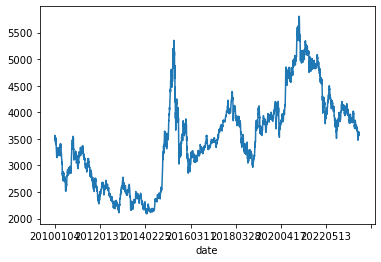

In [7]:
hs300.plot()

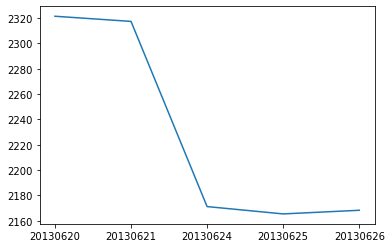

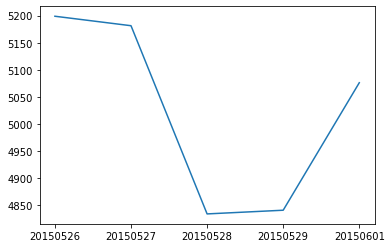

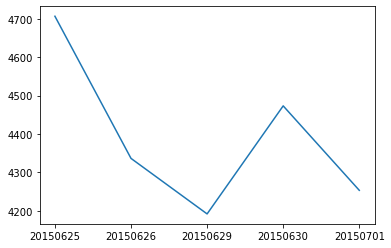

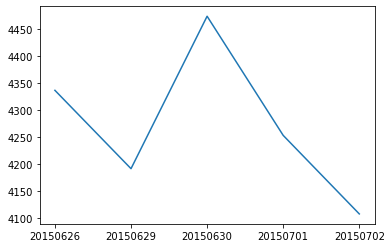

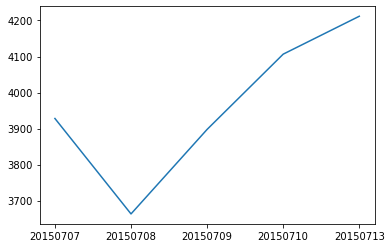

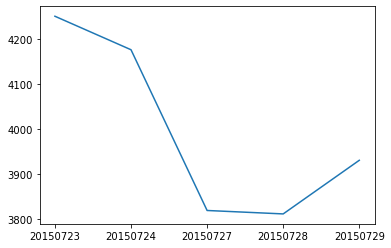

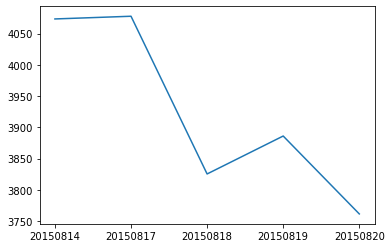

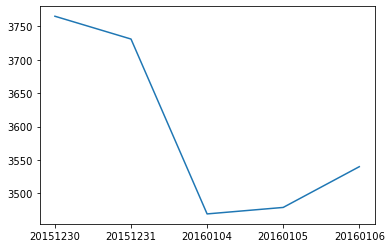

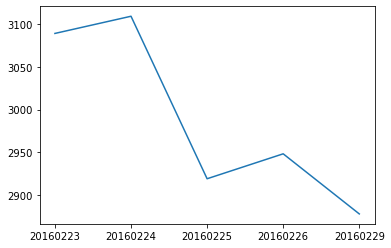

In [23]:
date_up_down = up_down[up_down > 0.06].index
for date in date_up_down:
    date_id = hs300_close.index.get_loc(date)
    plt.plot(hs300_close.iloc[date_id-2:date_id+3])
    plt.show()

In [16]:
# for date in date_up:
#     date_id = hs300.index.get_loc(date)
#     plt.plot(hs300.iloc[date_id-5:date_id+5])
#     plt.title(date)
#     plt.show()

In [24]:
close = datadaily.close
hbjt = close['SH601636']
hbjt

20171009    5.369986
20171010    5.390007
20171011    5.200000
20171012    5.190007
20171013    5.169986
              ...   
20240919    4.870000
20240920    4.810000
20240923    4.740000
20240924    5.000000
20240925    5.080000
Name: SH601636, Length: 1695, dtype: float64

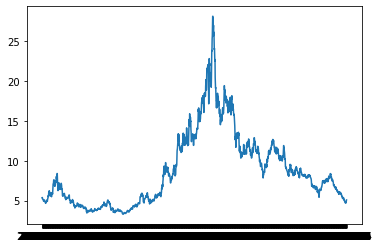

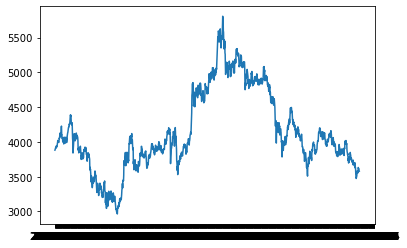

In [30]:
hbjt.index = [str(i) for i in hbjt.index]
plt.plot(hbjt)
plt.show()
plt.plot(hs300[hbjt.index])
plt.show()

Index(['20100104', '20100105', '20100106', '20100107', '20100108', '20100111',
       '20100112', '20100113', '20100114', '20100115',
       ...
       '20231031', '20231101', '20231102', '20231103', '20231106', '20231107',
       '20231108', '20231109', '20231110', '20231113'],
      dtype='object', name='date', length=3367)

In [26]:
data2023 = pd.read_hdf('/mnt/datadisk2/aglv/aglv/lab_aglv/data2023.h5')
data2023

Open  Close   High    Low  LastVolume  \
Date     InstrumentID EndTime                                           
20230103 SZ000001     09:31    13.20  13.16  13.23  13.06   3725537.0   
                      09:32    13.16  13.14  13.18  13.11   1122500.0   
                      09:33    13.14  13.17  13.17  13.11   1284694.0   
                      09:34    13.17  13.20  13.20  13.16   1218457.0   
                      09:35    13.20  13.19  13.19  13.16   1066087.0   
...                              ...    ...    ...    ...         ...   
20231012 SH689009     14:56    33.94  33.88  33.94  33.88     23275.0   
                      14:57    33.92  33.89  33.92  33.86      9297.0   
                      14:58    33.89  33.89  33.89  33.89         0.0   
                      14:59    33.89  33.89  33.89  33.89         0.0   
                      15:00    33.77  33.77  33.77  33.77     62011.0   

                               LastTurnOver  
Date     InstrumentID EndTime                
20230103 SZ000001     09:31    4.894731e+07  
                      09:32    1.473833e+07  
                      09:33    1.688369e+07  
                      09:34    1.605823e+07  
                      09:35    1.404670e+07  
...                                     ...  
20231012 SH689009     14:56    7.893110e+05  
                      14:57    3.150930e+05  
                      14:58    0.000000e+00  
                      14:59    0.000000e+00  
                      15:00    2.094111e+06  

[222608001 rows x 6 columns]

In [27]:
close = data2023['Close']
close = close.unstack(level='InstrumentID')
close

InstrumentID      SH600000  SH600004  SH600006  SH600007  SH600008  SH600009  \
Date     EndTime                                                               
20230103 09:31        7.22     14.91      5.54     15.78      2.83     57.46   
         09:32        7.23     14.92      5.53     15.82      2.83     57.39   
         09:33        7.24     14.87      5.57     15.87      2.84     57.31   
         09:34        7.25     14.99      5.56     15.80      2.83     57.48   
         09:35        7.23     14.87      5.57     15.80      2.83     57.39   
...                    ...       ...       ...       ...       ...       ...   
20231012 14:56        7.13     10.87      5.78     19.02      2.81     37.33   
         14:57        7.13     10.87      5.79     19.04      2.82     37.33   
         14:58        7.13     10.87      5.79     19.04      2.82     37.33   
         14:59        7.13     10.87      5.79     19.04      2.82     37.33   
         15:00        7.14     10.88      5.79     18.98      2.81     37.33   

InstrumentID      SH600010  SH600011  SH600012  SH600015  ...  SZ301519  \
Date     EndTime                                          ...             
20230103 09:31        1.92      7.61      7.32      5.18  ...       NaN   
         09:32        1.93      7.63      7.33      5.18  ...       NaN   
         09:33        1.94      7.67      7.33      5.18  ...       NaN   
         09:34        1.94      7.68      7.32      5.18  ...       NaN   
         09:35        1.94      7.70      7.32      5.18  ...       NaN   
...                    ...       ...       ...       ...  ...       ...   
20231012 14:56        1.73      7.81     10.83      5.72  ...     23.05   
         14:57        1.73      7.82     10.82      5.73  ...     23.06   
         14:58        1.73      7.82     10.81      5.73  ...     23.06   
         14:59        1.73      7.82     10.81      5.73  ...     23.06   
         15:00        1.72      7.81     10.83      5.71  ...     23.05   

InstrumentID      SZ301520  SZ301525  SZ301528  SZ301529  SZ301533  SZ301548  \
Date     EndTime                                                               
20230103 09:31         NaN       NaN       NaN       NaN       NaN       NaN   
         09:32         NaN       NaN       NaN       NaN       NaN       NaN   
         09:33         NaN       NaN       NaN       NaN       NaN       NaN   
         09:34         NaN       NaN       NaN       NaN       NaN       NaN   
         09:35         NaN       NaN       NaN       NaN       NaN       NaN   
...                    ...       ...       ...       ...       ...       ...   
20231012 14:56       65.80    101.99     84.05     44.24     41.43     61.38   
         14:57       65.65    101.81     84.08     44.28     41.39     61.37   
         14:58       65.64    101.81     84.10     44.28     41.39     61.34   
         14:59       65.64    101.81     84.10     44.28     41.39     61.34   
         15:00       65.64    101.90     84.29     44.35     41.40     61.33   

InstrumentID      SZ301550  SZ301558  SZ301559  
Date     EndTime                                
20230103 09:31         NaN       NaN       NaN  
         09:32         NaN       NaN       NaN  
         09:33         NaN       NaN       NaN  
         09:34         NaN       NaN       NaN  
         09:35         NaN       NaN       NaN  
...                    ...       ...       ...  
20231012 14:56       50.40     14.08     22.72  
         14:57       50.21     14.01     22.69  
         14:58       50.18     14.00     22.69  
         14:59       50.18     14.00     22.69  
         15:00       50.30     14.01     22.69  

[44718 rows x 5111 columns]

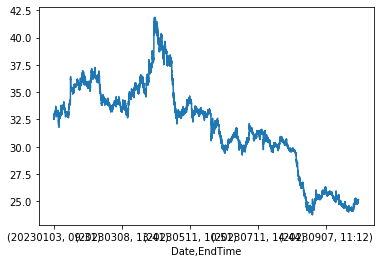

In [36]:
sgw = close['SH600460']
sgw.plot()

In [31]:
data_828 = close.xs('20230828', level='Date')
data_829 = close.xs('20230829', level='Date')

In [34]:
data_828['SH600460']

EndTime
09:30    25.15
09:31    25.20
09:32    24.86
09:33    24.89
09:34    24.70
         ...  
14:56    24.29
14:57    24.29
14:58    24.29
14:59    24.29
15:00    24.28
Name: SH600460, Length: 241, dtype: float64

In [7]:
eg = close['SH600000']
eg.index = [str(i) for i in eg.index]
eg.plot()

IndentationError: unexpected indent (<ipython-input-7-3ce0b2559f02>, line 3)

In [8]:
high = datadaily.high
low = datadaily.low

In [9]:
high

InstrumentID,BJ430017,BJ430047,BJ430090,BJ430139,BJ430198,BJ430300,BJ430418,BJ430425,BJ430476,BJ430478,...,SZ301589,SZ301591,SZ301596,SZ301600,SZ301603,SZ301606,SZ301607,SZ301608,SZ301611,SZ301618
date,,,,,,,,,,,,,,,,,,,,,
20171009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20171010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20171011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20171012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20171013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20240924,10.77,10.4,2.87,7.17,6.39,7.08,13.55,9.22,6.29,12.21,...,163.48,29.2000,59.5900,52.5100,35.96,27.2500,32.30,52.08,29.2500,NaN
20240925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,168.20,30.6000,61.9300,52.1800,37.25,27.9400,33.00,53.75,32.6700,NaN
20240926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,167.74,30.7900,64.2800,51.4799,37.43,27.6900,32.50,51.92,32.1500,NaN


In [10]:
up_down = high / low - 1
up_down

InstrumentID,BJ430017,BJ430047,BJ430090,BJ430139,BJ430198,BJ430300,BJ430418,BJ430425,BJ430476,BJ430478,...,SZ301589,SZ301591,SZ301596,SZ301600,SZ301603,SZ301606,SZ301607,SZ301608,SZ301611,SZ301618
date,,,,,,,,,,,,,,,,,,,,,
20171009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20171010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20171011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20171012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20171013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20240924,0.026692,0.034826,0.036101,0.03913,0.096055,0.036603,0.037519,0.047727,0.032841,0.037383,...,0.067590,0.038038,0.073694,0.081343,0.045048,0.051312,0.060059,0.051909,0.084941,NaN
20240925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.043036,0.044012,0.037527,0.047791,0.033001,0.033666,0.037410,0.045720,0.127329,NaN
20240926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.052123,0.035654,0.078162,0.042948,0.025199,0.032824,0.041667,0.024063,0.043154,NaN


In [ ]:
up_down['']